# SSNR analysis
---

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr

In [4]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

## White noise
---
### Generate noisy images

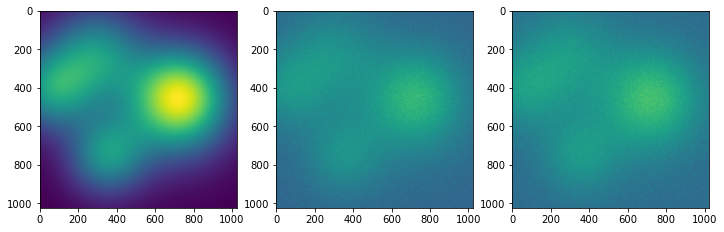

In [5]:
# Parameters
np.random.seed(123)
SNR_set = 1

# Generate image
image = ssnr.generate_image(1024, 1024)
var = np.var(image)
# Add noise
noisy_1 = image + ssnr.white_noise(var / SNR_set, image.shape)
noisy_2 = image + ssnr.white_noise(var / SNR_set, image.shape)

# Plot images
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes[0].imshow(image)
axes[1].imshow(noisy_1)
axes[2].imshow(noisy_2);

### PSD

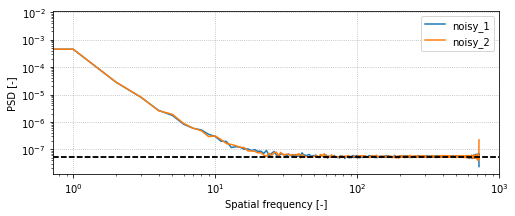

In [6]:
# Calculate PSDs and noise floors
fftnorm_1, floor_1 = ssnr.PSD_floor(noisy_1)
PSD_az_1, _ = ssnr.azimuthalAverage(fftnorm_1)
fftnorm_2, floor_2 = ssnr.PSD_floor(noisy_2)
PSD_az_2, _ = ssnr.azimuthalAverage(fftnorm_2)

# Plot PSDs and noise floors
fig, ax = plt.subplots(figsize=(8, 3))
ax.loglog(PSD_az_1, label='noisy_1')
ax.loglog(PSD_az_2, label='noisy_2')
ax.axhline(floor_1, c='k', ls='--')
ax.axhline(floor_2, c='k', ls='--')
ax.set_xlabel('Spatial frequency [-]')
ax.set_ylabel('PSD [-]')
ax.legend()
ax.grid(ls=':')

### SSNR

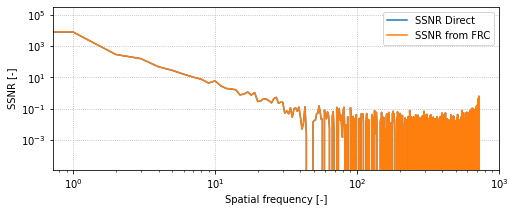

In [7]:
# Direct SSNR calculation
SSNR_data = ssnr.SSNR_ring([noisy_1, noisy_2])
# SSNR from FRC
FRC_data = ssnr.FRC_ring(noisy_1, noisy_2)
SSNR_data_ = FRC_data / (1 - FRC_data)

# Plot SSNR data
fig, ax = plt.subplots(figsize=(8, 3))
ax.loglog(SSNR_data, label='SSNR Direct')
ax.loglog(SSNR_data_.real, label='SSNR from FRC')
ax.set_xlabel('Spatial frequency [-]')
ax.set_ylabel('SSNR [-]')
ax.legend()
ax.grid(ls=':')

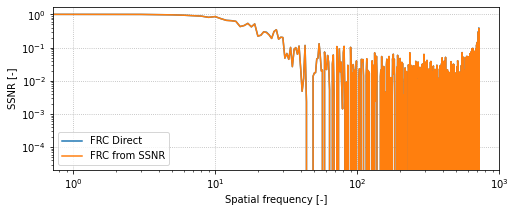

In [8]:
# Calculate FRC from SSNR
FRC_data_ = SSNR_data / (SSNR_data + 1)

# Plot FRC data
fig, ax = plt.subplots(figsize=(8, 3))
ax.loglog(FRC_data.real, label='FRC Direct')
ax.loglog(FRC_data_, label='FRC from SSNR')
ax.set_xlabel('Spatial frequency [-]')
ax.set_ylabel('SSNR [-]')
ax.legend()
ax.grid(ls=':')

### SNR calculations

In [9]:
# From PSD
SNR_PSD = (ssnr.SNR_PSD(noisy_1) +
           ssnr.SNR_PSD(noisy_2)) / 2
# From FRC
F = ssnr.FRC_full(noisy_1, noisy_2)
SNR_FRC = F / (1 - F)
# From SSNR
SNR_SSNR = ssnr.SSNR_full([noisy_1, noisy_2])

# Output
out = f"""\
True SNR........ {SNR_set:.10f}
SNR from PSD.... {SNR_PSD:.10f}
SNR from FRC.... {SNR_FRC.real:.10f}
SNR from SSNR... {SNR_SSNR:.10f}
"""
print(out)

True SNR........ 1.0000000000
SNR from PSD.... 1.0003346732
SNR from FRC.... 0.9988920498
SNR from SSNR... 0.9988911800



## Non-white noise
---
Show that SNR calculation from PSD is invalid since there is no well-defined noise floor

### Generate noisy images

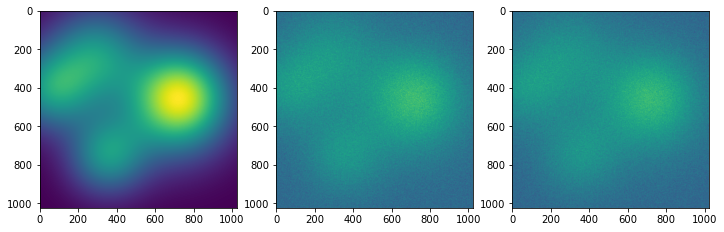

In [10]:
# Generate nonwhite noisy images
noisy_1 = image + ssnr.nonwhite_noise(var / SNR_set, image.shape)
noisy_2 = image + ssnr.nonwhite_noise(var / SNR_set, image.shape)

# Plot images
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes[0].imshow(image)
axes[1].imshow(noisy_1)
axes[2].imshow(noisy_2);

### PSD

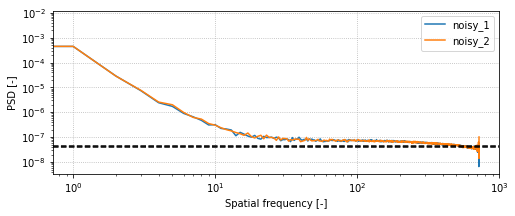

In [11]:
# Calculate PSDs and noise floors
fftnorm_1, floor_1 = ssnr.PSD_floor(noisy_1)
PSD_az_1, _ = ssnr.azimuthalAverage(fftnorm_1)
fftnorm_2, floor_2 = ssnr.PSD_floor(noisy_2)
PSD_az_2, _ = ssnr.azimuthalAverage(fftnorm_2)

# Plot PSDs and noise floors
fig, ax = plt.subplots(figsize=(8, 3))
ax.loglog(PSD_az_1, label='noisy_1')
ax.loglog(PSD_az_2, label='noisy_2')
ax.axhline(floor_1, c='k', ls='--')
ax.axhline(floor_2, c='k', ls='--')
ax.set_xlabel('Spatial frequency [-]')
ax.set_ylabel('PSD [-]')
ax.legend()
ax.grid(ls=':')

### SNR calculations

In [12]:
# From PSD
SNR_PSD = (ssnr.SNR_PSD(noisy_1) +
           ssnr.SNR_PSD(noisy_2)) / 2
# From FRC
F = ssnr.FRC_full(noisy_1, noisy_2)
SNR_FRC = F / (1 - F)
# From SSNR
SNR_SSNR = ssnr.SSNR_full([noisy_1, noisy_2])

# Output
out = f"""\
True SNR........ {SNR_set:.10f}
SNR from PSD.... {SNR_PSD:.10f}
SNR from FRC.... {SNR_FRC.real:.10f}
SNR from SSNR... {SNR_SSNR:.10f}
"""
print(out)

True SNR........ 1.0000000000
SNR from PSD.... 1.5615331218
SNR from FRC.... 1.0023940705
SNR from SSNR... 1.0023930095



## Batch of images with white noise
---

In [13]:
# Set up DataFrame
df = pd.DataFrame(columns=['SNR', 'SSNR', 'SSNR FRC', 'SNR PSD'])
df['SNR'] = np.geomspace(1e-4, 1e4, 30)

for i, row in df.iterrows():
    SNR = row['SNR']

    # Generate noisy images
    noisy_1 = image + ssnr.white_noise(var/SNR, image.shape)
    noisy_2 = image + ssnr.white_noise(var/SNR, image.shape)

    # (S)SNR calculations
    df.loc[i, 'SSNR'] = ssnr.SSNR_full([noisy_1, noisy_2])
    F = ssnr.FRC_full(noisy_1, noisy_2)
    df.loc[i, 'SSNR FRC'] = (F / (1-F)).real
    df.loc[i, 'SNR PSD'] = ssnr.SNR_PSD(noisy_1)

# Preview
df[::5]

,SNR,SSNR,SSNR FRC,SNR PSD
0,0.000100,0.000154366,0.000154366,-0.000724908
5,0.002395,0.00206362,0.00206363,0.00449303
10,0.057362,0.0580505,0.0580505,0.0599677
15,1.373824,1.37411,1.37411,1.37011
20,32.903446,32.9496,32.9497,32.9611
25,788.046282,789.93,789.93,788.9


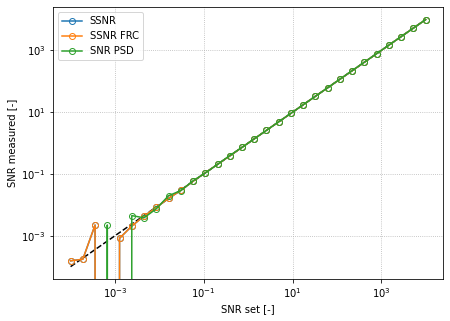

In [14]:
# Plot SNR calculations
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df['SNR'], df['SNR'], 'k--')
for s in ['SSNR', 'SSNR FRC', 'SNR PSD']:
    ax.plot(df['SNR'], df[s], 'o-', mfc='none', label=s)
# Aesthetics
ax.set_xlabel('SNR set [-]')
ax.set_ylabel('SNR measured [-]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(ls=':')

## Batch of images with non-white noise
---

In [15]:
# Set up DataFrame
df = pd.DataFrame(columns=['SNR', 'SSNR', 'SSNR FRC', 'SNR PSD'])
df['SNR'] = np.geomspace(1e-4, 1e4, 30)

for i, row in df.iterrows():
    SNR = row['SNR']

    # Generate noisy images
    noisy_1 = image + ssnr.nonwhite_noise(var/SNR, image.shape)
    noisy_2 = image + ssnr.nonwhite_noise(var/SNR, image.shape)

    # (S)SNR calculations
    df.loc[i, 'SSNR'] = ssnr.SSNR_full([noisy_1, noisy_2])
    F = ssnr.FRC_full(noisy_1, noisy_2)
    df.loc[i, 'SSNR FRC'] = (F / (1-F)).real
    df.loc[i, 'SNR PSD'] = ssnr.SNR_PSD(noisy_1)

# Preview
df[::5]

,SNR,SSNR,SSNR FRC,SNR PSD
0,0.000100,-0.000553335,-0.000553335,0.279314
5,0.002395,0.00320973,0.00320973,0.280219
10,0.057362,0.0578955,0.0578955,0.347794
15,1.373824,1.37624,1.37624,2.03391
20,32.903446,32.9055,32.9055,42.4548
25,788.046282,788.105,788.105,1009.69


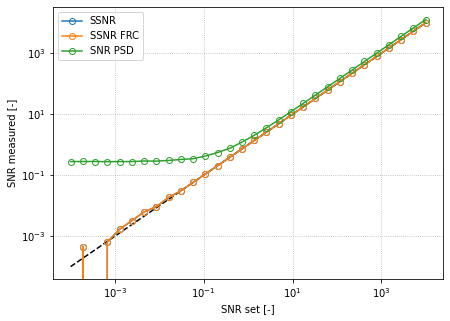

In [16]:
# Plot SNR calculations
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df['SNR'], df['SNR'], 'k--')
for s in ['SSNR', 'SSNR FRC', 'SNR PSD']:
    ax.plot(df['SNR'], df[s], 'o-', mfc='none', label=s)
# Aesthetics
ax.set_xlabel('SNR set [-]')
ax.set_ylabel('SNR measured [-]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(ls=':')